<a href="https://colab.research.google.com/github/shyamsundar233/Mask-Detection/blob/main/maskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

In [ ]:
train_path = '/content/drive/MyDrive/Datasets/maskdata/maskdata/train'
test_path = '/content/drive/MyDrive/Datasets/maskdata/maskdata/test'
validation_path = '/content/drive/MyDrive/Datasets/maskdata/maskdata/validation'

In [ ]:
train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

train_dataset = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_dataset = ImageDataGenerator( rescale = 1.0/255. )

train_dataset = train.flow_from_directory(train_path,
                                          target_size=(224,224),
                                          batch_size=10,
                                          class_mode='binary')

test_dataset = test.flow_from_directory(test_path,
                                          target_size=(224,224),
                                          batch_size=10,
                                          class_mode='binary')

CLASSES=['GOOD! YOU ARE SAFE!!','PLEASE!! WEAR YOUR MASK!']

Found 616 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


In [ ]:
train_dataset.class_indices

{'with_mask': 0, 'without_mask': 1}

In [ ]:
base = VGG16(input_shape=(224,224,3),
             include_top=False,
             weights='imagenet')

for layer in base.layers:
  layer.trainable=False

x = tf.keras.layers.Flatten()(base.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

vgghist = model.fit(train_dataset,
                    validation_data = test_dataset,
                    epochs = 10,
                    steps_per_epoch = len(train_dataset),
                    validation_steps = len(test_dataset))

58892288/58889256 [==============================] - 0s 0us/step
Epoch 1/10
62/62 [==============================] - 205s 3s/step - loss: 0.3256 - accuracy: 0.8588 - val_loss: 0.0835 - val_accuracy: 0.9596
Epoch 2/10
62/62 [==============================] - 5s 74ms/step - loss: 0.0580 - accuracy: 0.9773 - val_loss: 0.0424 - val_accuracy: 0.9848
Epoch 3/10
62/62 [==============================] - 5s 74ms/step - loss: 0.0373 - accuracy: 0.9870 - val_loss: 0.0298 - val_accuracy: 0.9899
Epoch 4/10
62/62 [==============================] - 5s 75ms/step - loss: 0.0364 - accuracy: 0.9838 - val_loss: 0.0362 - val_accuracy: 0.9848
Epoch 5/10
62/62 [==============================] - 5s 75ms/step - loss: 0.0251 - accuracy: 0.9870 - val_loss: 0.0597 - val_accuracy: 0.9747
Epoch 6/10
62/62 [==============================] - 5s 74ms/step - loss: 0.0081 - accuracy: 0.9968 - val_loss: 0.0193 - val_accuracy: 0.9949
Epoch 7/10
62/62 [==============================] - 5s 75ms/step - loss: 0.0119 - accurac

In [ ]:
val_loss,val_acc = model.evaluate(train_dataset)
print(val_loss,val_acc)

62/62 [==============================] - 3s 53ms/step - loss: 1.3638e-04 - accuracy: 1.0000
0.0001363768824376166 1.0


In [ ]:
print(model)
model.save('maskDetector.model')
new_model = tf.keras.models.load_model('maskDetector.model')

INFO:tensorflow:Assets written to: maskDetector.model/assets


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

SAY CHEESE!!


In [ ]:
from IPython.display import Image
try:
  print("\n\n\t\t\t\t\tSAY CHEESE!!\n")
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  #display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

image = load_img(filename,target_size=(224,224))

plt.imshow(image)
plt.show()
  
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

out = model.predict(image)
class_name = (int)(out)

print("\n\t\t" + CLASSES[class_name] + "\n\n")  



					SAY CHEESE!!



<IPython.core.display.Javascript object>

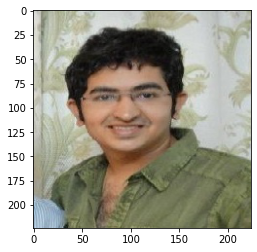


		PLEASE!! WEAR YOUR MASK!




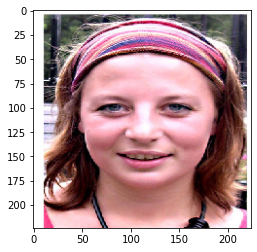


		PLEASE!! WEAR YOUR MASK!




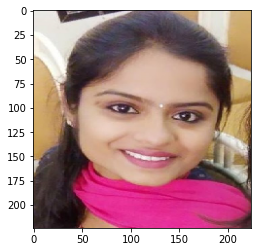


		PLEASE!! WEAR YOUR MASK!




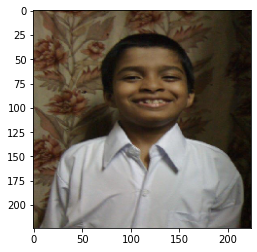


		PLEASE!! WEAR YOUR MASK!




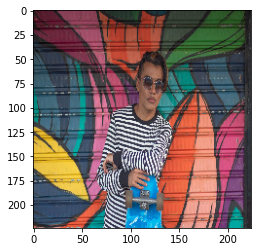


		GOOD! YOU ARE SAFE!!




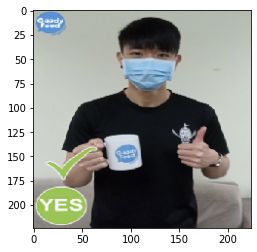


		GOOD! YOU ARE SAFE!!




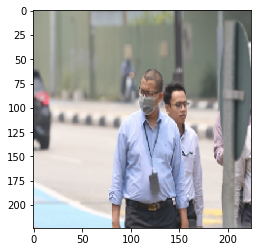


		GOOD! YOU ARE SAFE!!




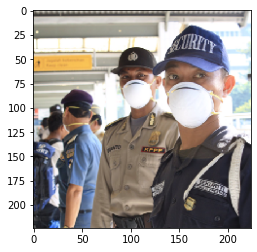


		GOOD! YOU ARE SAFE!!




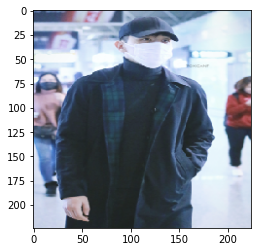


		GOOD! YOU ARE SAFE!!




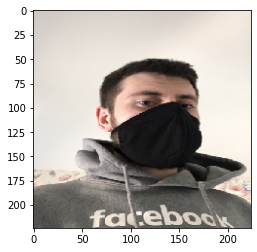


		GOOD! YOU ARE SAFE!!




In [ ]:

for i in os.listdir(validation_path):
  image = load_img(validation_path + '//' + i,target_size=(224,224))

  plt.imshow(image)
  plt.show()
  
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)

  out = model.predict(image)
  class_name = (int)(out)

  print("\n\t\t" + CLASSES[class_name] + "\n\n")  
  